In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr
from statsmodels.tsa.arima.model import ARIMA 
import seaborn as sns
import os
import glob

matplotlib.rcParams['figure.figsize'] = (25, 5)
sns.set()
from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC
from BasicAutoEncoder.Metric import CCACorr
from Simulation.defaultCfg import cfg as defaultCfg
from Simulation.results import logResults, loadResults, RESULT_DIR

print("All available logs: \n","\n".join(glob.glob(f"{RESULT_DIR}*/*", recursive=True)))

All available logs: 
 ./Results/30/12_assymetric_T1000_06032023_23:19:46
./Results/30/1_OverParametrization_T10000_05242023_02:47:02
./Results/30/8_assymetric_T1000_06032023_16:50:32
./Results/30/4_OverParametrization_T100_05242023_13:54:31
./Results/30/3_OverParametrization_T100_05242023_13:38:07
./Results/30/2_OverParametrization_T10000_05242023_13:20:21
./Results/30/7_assymetric_T1000_06032023_16:05:10
./Results/30/5_assymetric_T100_06032023_14:56:04
./Results/30/9_assymetric_T10000_06032023_20:25:41
./Results/30/10_assymetric_T10000_06032023_20:50:43
./Results/30/6_assymetric_T100_06032023_15:05:41
./Results/30/0_OverParametrization_T1000_05212023_15:04:07
./Results/30/13_assymetric_T100_06032023_23:47:02
./Results/30/11_assymetric_T10000_06032023_22:28:10
./Results/20/0_OverParametrization_T100_05172023_16:14:35
./Results/3/2_CorrectSpecification_05092023_23:28:51
./Results/3/3_Linear_05092023_23:59:22
./Results/3/1_CorrectSpecification_05092023_23:08:10
./Results/3/0_CorrectSpeci

## Input logfile and show model architecture

In [17]:
dgpIndex = 30
experimentName = '0_OverParametrization_T1000_05212023_15:04:07'
train_hist, mod, cfg = loadResults(dgpIndex, experimentName)
print(mod)

AutoEncoder(
  (enc): Encoder(
    (sequential): Sequential(
      (linear_0): Linear(in_features=50, out_features=36, bias=True)
      (activation_0): Sigmoid()
      (linear_1): Linear(in_features=36, out_features=23, bias=True)
      (activation_1): Sigmoid()
      (linear_2): Linear(in_features=23, out_features=10, bias=True)
      (activation_2): Sigmoid()
    )
  )
  (dec): Decoder(
    (sequential): Sequential(
      (linear_0): Linear(in_features=10, out_features=23, bias=True)
      (activation_0): Sigmoid()
      (linear_1): Linear(in_features=23, out_features=36, bias=True)
      (activation_1): Sigmoid()
      (linear_2): Linear(in_features=36, out_features=50, bias=True)
      (activation_2): Sigmoid()
    )
  )
)


In [3]:
print(cfg.enc_hidden_dim)
print(cfg.dec_hidden_dim)
print(cfg.enc_activation)
print(cfg.dec_activation)
print(cfg.T_train)
print(cfg.T_val)
print(cfg.T_test)

[50, 40, 30, 20, 10]
[10, 50]
<class 'torch.nn.modules.activation.Sigmoid'>
<class 'torch.nn.modules.linear.Identity'>
1000
1024
7168


## Obtain Data
Obtain the simulated $y$ and $f$

Decoder(
  (sequential): Sequential(
    (linear_0): Linear(in_features=10, out_features=20, bias=True)
    (activation_0): Sigmoid()
    (linear_1): Linear(in_features=20, out_features=40, bias=True)
    (activation_1): Sigmoid()
    (linear_2): Linear(in_features=40, out_features=60, bias=True)
    (activation_2): Sigmoid()
    (linear_3): Linear(in_features=60, out_features=80, bias=True)
    (activation_3): Sigmoid()
    (linear_4): Linear(in_features=80, out_features=50, bias=True)
    (activation_4): Sigmoid()
  )
)
(1000, 50) (1024, 50) (14360, 50)


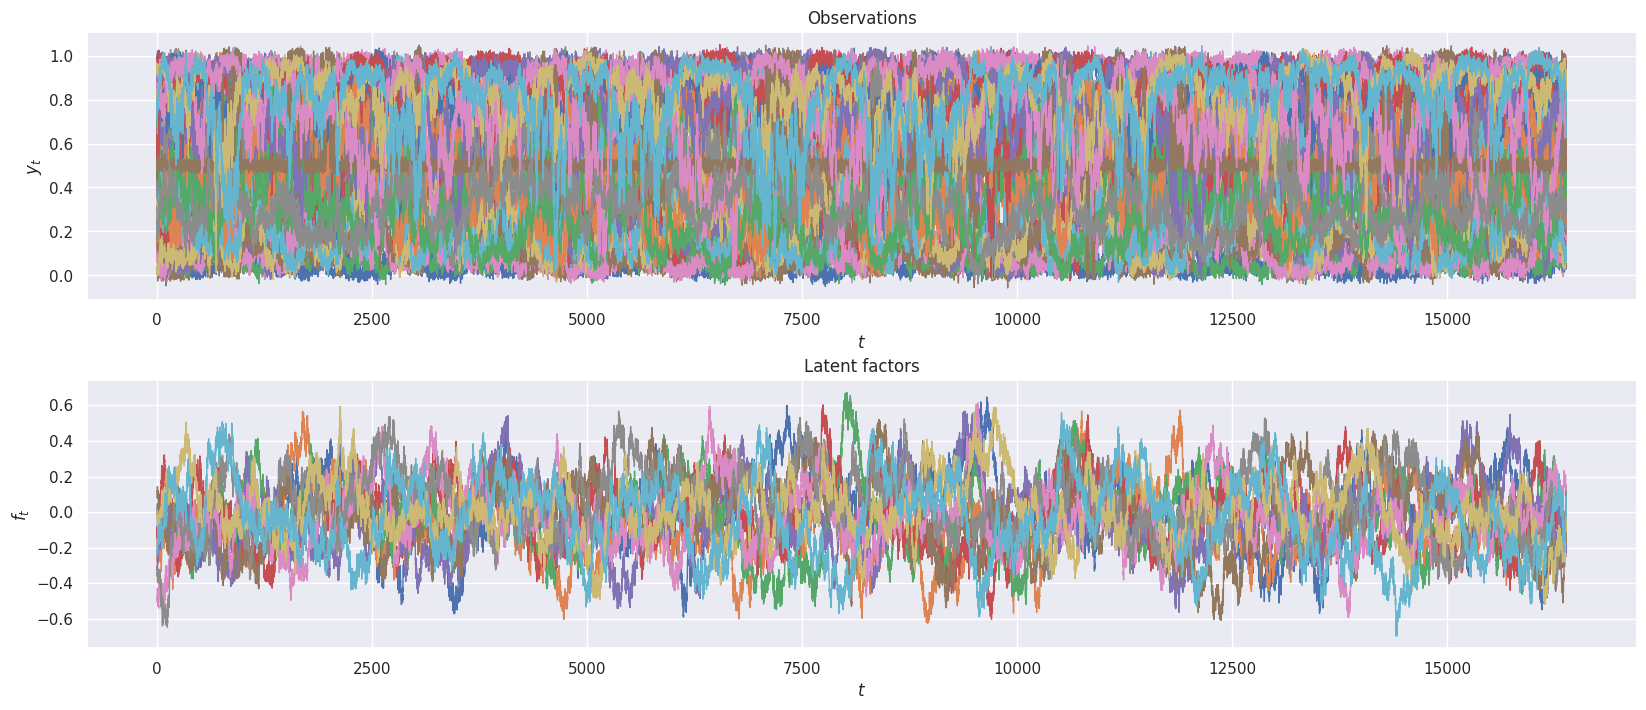

In [4]:
if cfg.use_default_data:
    f,y,dec = dgp.getSaved(cfg.saved_index, T=cfg.T)
    cfg.factor_dim = f.shape[1]
    cfg.obs_dim = y.shape[1]
else:
    #custom dgp
    dec = Decoder(hidden_dim=[cfg.factor_dim, 20, 40, 80, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False, use_xavier=False)
    f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=True, centered=True)
print(dec)
f_train = f[0:cfg.T_train]
f_val = f[cfg.T_train:cfg.T_train+cfg.T_val]
f_test = f[cfg.T_train+cfg.T_val:]

y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]
print(y_train.shape, y_val.shape, y_test.shape)

fig,ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(y, linewidth=1)
ax[0].set_title('Observations')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y_t$')
ax[1].plot(f, linewidth=1)
ax[1].set_title('Latent factors')
ax[1].set_ylabel('$f_t$')
ax[1].set_xlabel('$t$')
plt.subplots_adjust(hspace=0.3)

### Train & val loss

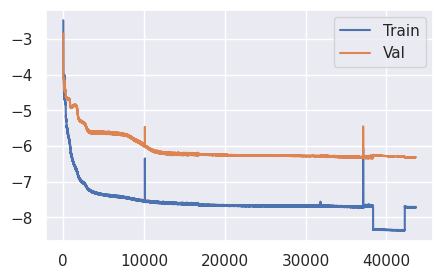

In [18]:
plot_train_hist(train_hist, log=True)

### Convergence of mu of epsilon

In [5]:
plt.plot(np.stack(errorProcess.fit_hist['mu']));

NameError: name 'errorProcess' is not defined

### Reconstruction of y

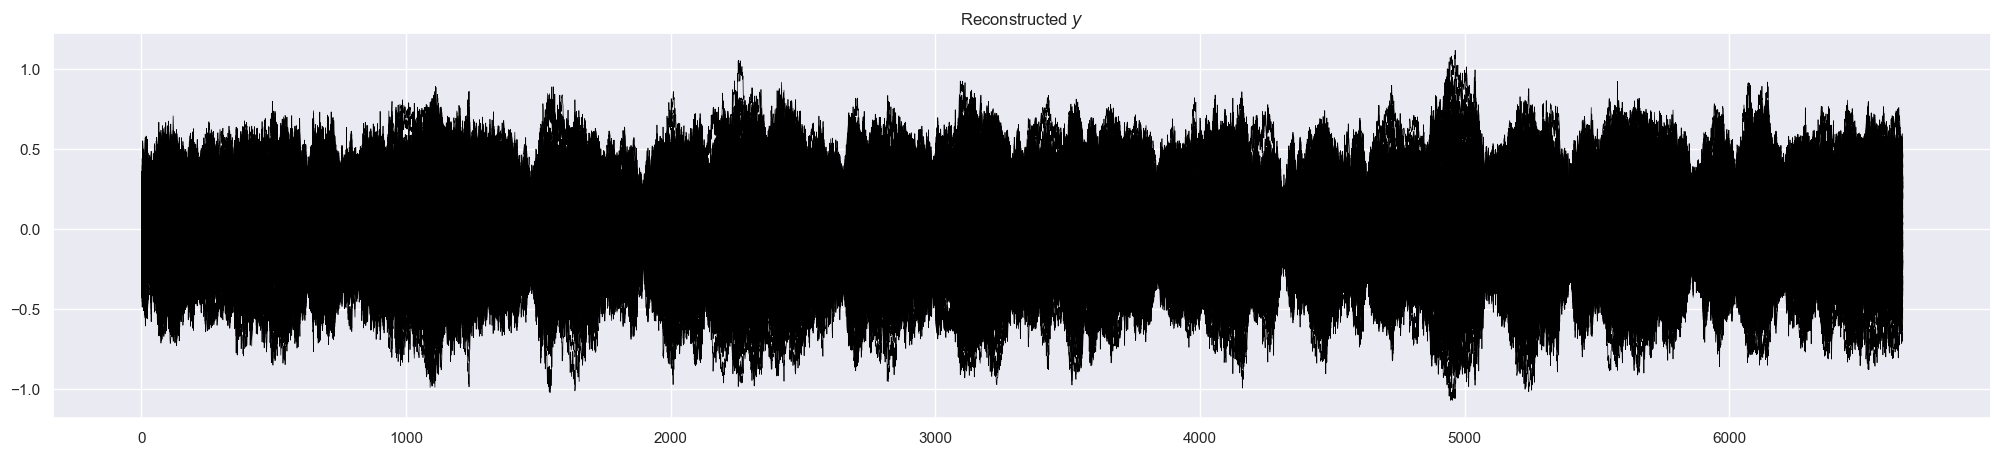

In [55]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);


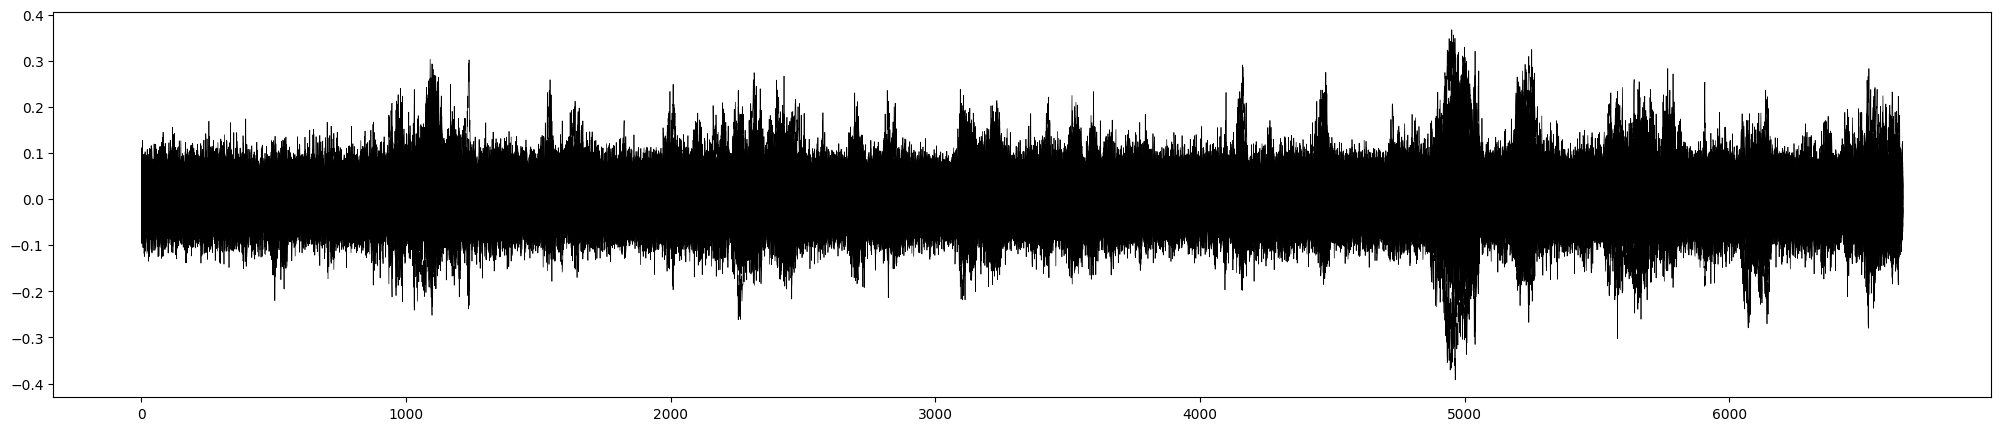

In [39]:
y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y, c='black', linewidth=0.5);

### Factor estimation

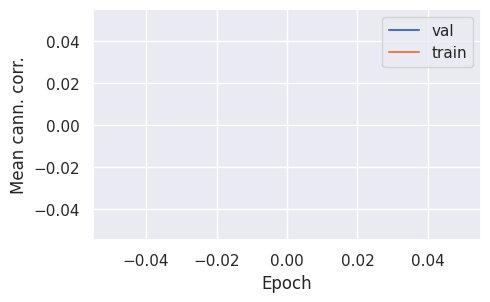

In [6]:
plt.figure(figsize=(5,3))
plt.plot(train_hist['val_CCA_mean_corr'][100:], label='val')
plt.plot(train_hist['train_CCA_mean_corr'][100:], label='train')

plt.xlabel('Epoch')
plt.ylabel('Mean cann. corr.')
plt.legend()

Text(0, 0.5, 'CCA')

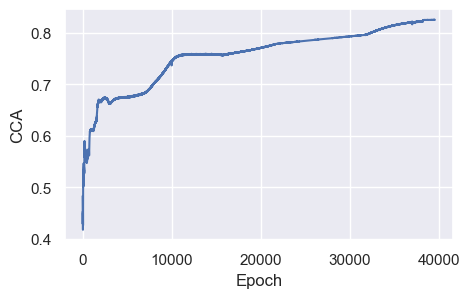

In [29]:
plt.figure(figsize=(5,3))
z = np.array(train_hist['val_CCA_mean_corr'][100:])
zx = np.array(range(len(z)))
zxinterp = zx[~np.isnan(z)]
zinterp = np.interp(zxinterp, zx, z)
plt.plot(zinterp, label='train')

plt.xlabel('Epoch')
plt.ylabel('CCA')

In [30]:
z

array([0.48291108, 0.48155016, 0.48018641, ..., 0.82551004, 0.82550795,
       0.8254684 ])

In [19]:
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
cancorr = CanCorr(f_train_hat, f_train)
cc = np.mean(cancorr.cancorr)
print(f"cc on train data: {cc}")
f_test_hat = mod.enc(torch.Tensor(y_test).float()).detach().numpy()
cancorr = CanCorr(f_test_hat, f_test)
cc = np.mean(cancorr.cancorr)
print(f"cc on test data: {cc}")

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_train_hat, f_train)
X_c, Y_c = cca.transform(f_train_hat, f_train)

print("cc on train data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_test_hat, f_test)
X_c, Y_c = cca.transform(f_test_hat, f_test)

print("cc on test data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  
print("cc R2 on test data: ", cca.score(f_test_hat, f_test))  

from evaluation import bootstrapCCA
bs = bootstrapCCA(f_hat=f_test_hat, f_true=f_test, n_bootstrap=10000, n_sample=1000)
print("Bootstrapped cca: mean, std, 95%ci", (np.mean(bs), np.std(bs), np.quantile(bs, [0.025, 0.975])))

y_test_hat = mod(torch.Tensor(y_test).float()).detach().numpy()
print(f'Mse on test data: {np.mean((y_test_hat - y_test)**2)}')

cc on train data: 0.8035626507708187
cc on test data: 0.7667062686661137
cc on train data:  0.8035625610680569
cc on test data:  0.7667061788418085
cc R2 on test data:  0.6302554959751743
Bootstrapped cca: mean, std, 95%ci (0.7677421412638321, 0.003925625089537838, array([0.76039835, 0.77561447]))
Mse on test data: 0.0028186473064124584


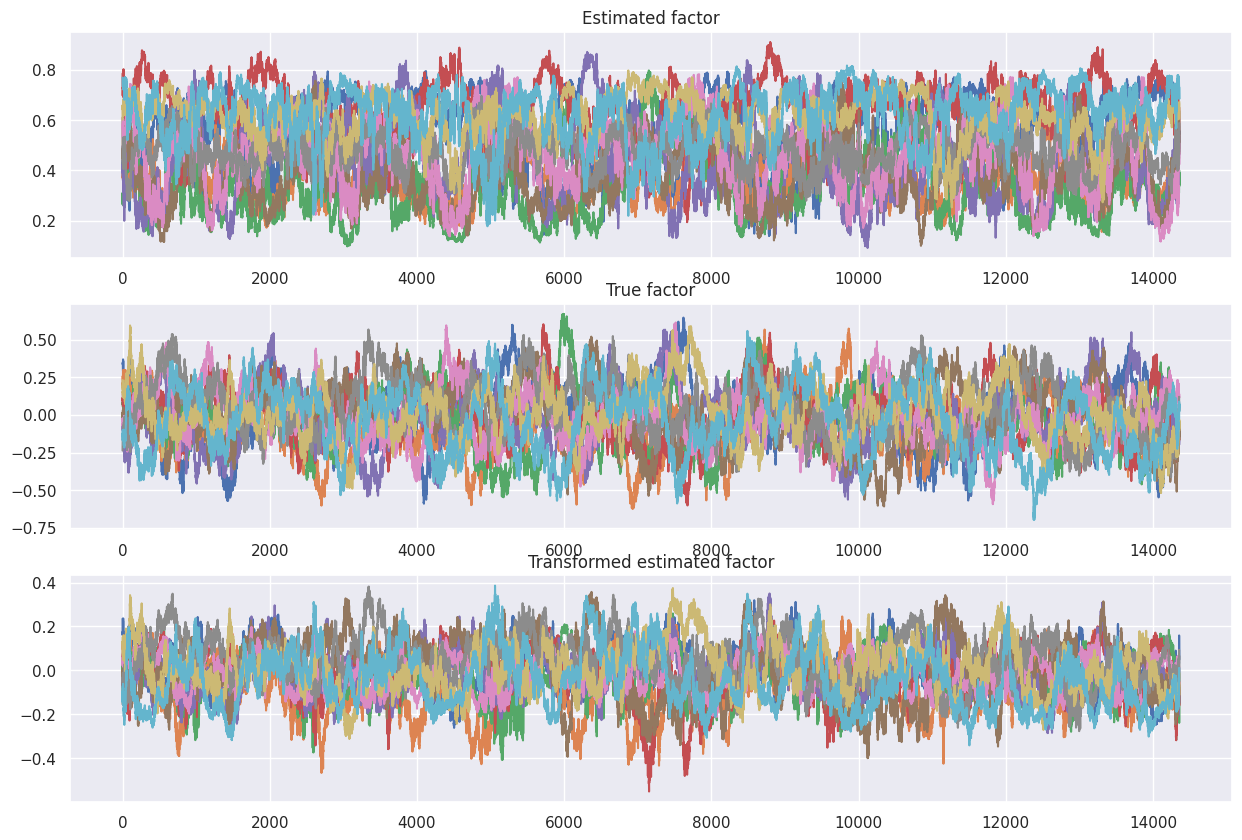

In [8]:
fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(f_test_hat);
ax[0].set_title('Estimated factor');
ax[1].plot(f_test);
ax[1].set_title('True factor');
ax[2].plot(cca.predict(f_test_hat));
ax[2].set_title('Transformed estimated factor');

In [33]:
f.shape

(16384, 10)

In [ ]:
fig,plots=plt.subplots(2,5)
for i,ax in enumerate(axs.flatten()):
    ax.plot(f_test[:,i], label="$\mathbb{f}_t$")
    ax.plot(f_test_hat[:,i], label="$\hat{\mathbb{f}}_t$")


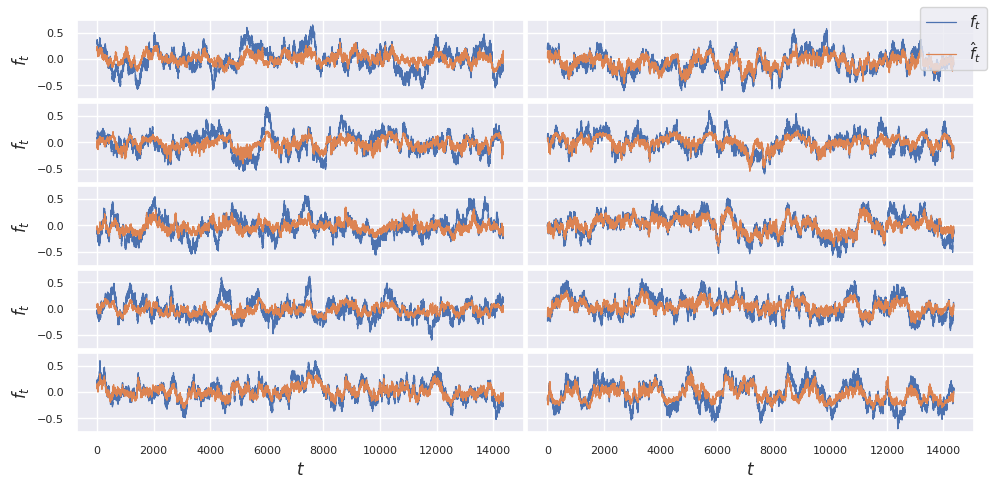

In [9]:
nCols = 2
offset = 0
fig,axs = plt.subplots(int(cfg.factor_dim/nCols),nCols, sharey=True, sharex=True, figsize=(10,5))
f_test_hat_trans = cca.predict(f_test_hat)
for i, ax in enumerate(axs.flatten()):
    ax.plot(f_test[:,i], label="$f_t$", linewidth=0.9)
    ax.plot(f_test_hat_trans[:,i], label="$\hat{f}_t$", linewidth=0.9)
    #ax.set_ylabel('$\mathbf{f}_t$')
    if i >= len(axs.flatten())-nCols:
        ax.set_xlabel('$t$')
    if i % nCols == 0:
        ax.set_ylabel('$f_t$')
        ax.tick_params(labelsize=8)
        
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)     
fig.tight_layout()
plt.subplots_adjust(wspace=0.008, hspace=0.05);
axs.flatten()[-1].tick_params(labelsize=8)


### Forecast

In [52]:
f_test_pred.shape

(7168, 10)

In [53]:
cfg.T_test

7168

1-step ahead  FMSE on the test set: 0.003649083198979497


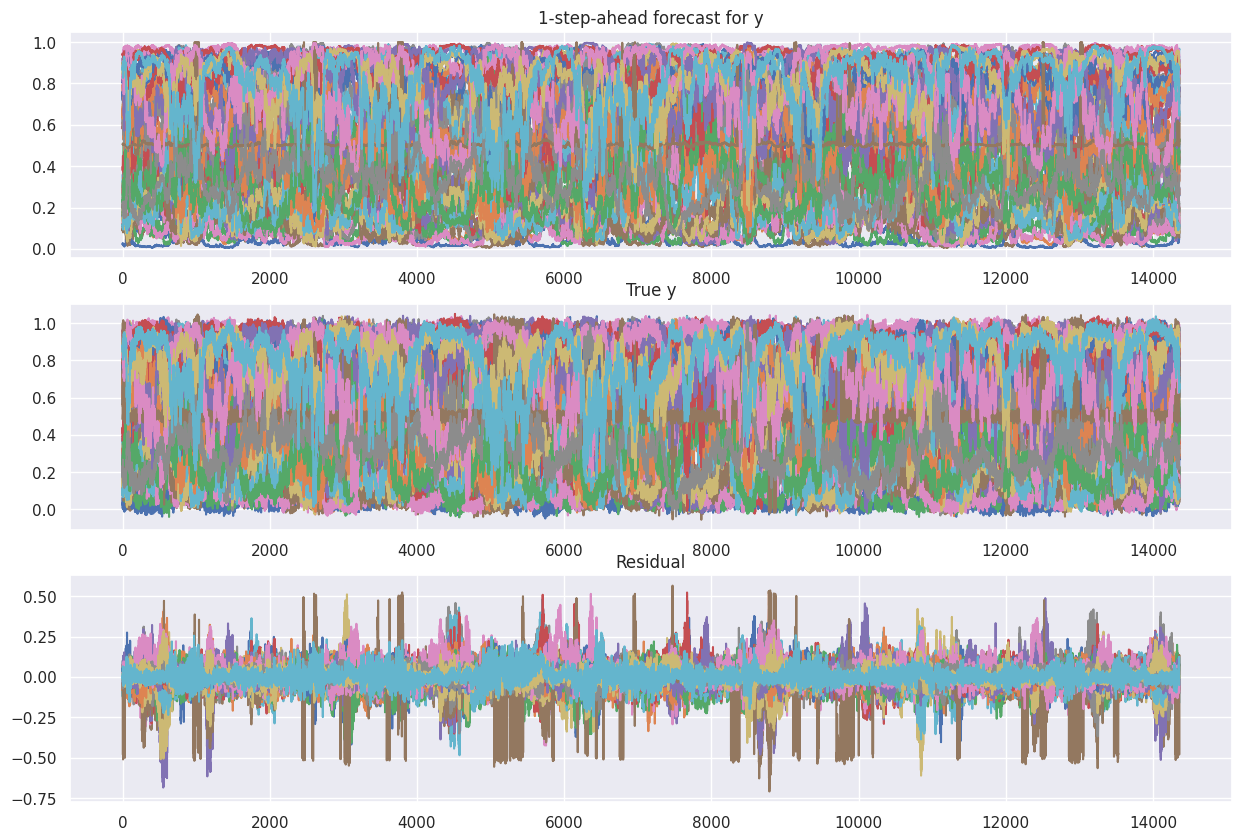

In [22]:
#forecast
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
f_hat = np.concatenate([f_train_hat, f_val_hat])
model = VAR(f_hat)
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)[cfg.T_train+cfg.T_val:]
y_test_pred = mod.dec(torch.Tensor(f_test_pred).float()).detach().numpy()

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test[2:]);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test[2:])**2)}")

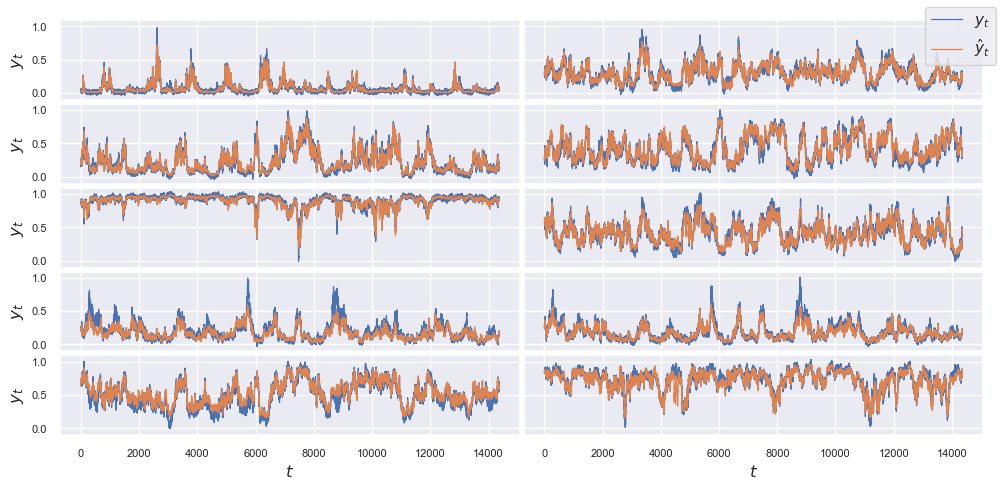

In [89]:
nCols = 2
offset = 0
nShow=10
skipSeries = 10
fig,axs = plt.subplots(int(nShow/nCols),nCols, sharey=True, sharex=True, figsize=(10,5))
f_test_hat_trans = cca.predict(f_test_hat)
for i, ax in enumerate(axs.flatten()):
    ax.plot(y_test[:,skipSeries+i], label="$y_t$", linewidth=0.9)
    ax.plot(y_test_pred[:,skipSeries+i], label="$\hat{y}_t$", linewidth=0.9)
    #ax.set_ylabel('$\mathbf{f}_t$')
    if i >= len(axs.flatten())-nCols:
        ax.set_xlabel('$t$')
    if i % nCols == 0:
        ax.set_ylabel('$y_t$')
        ax.tick_params(labelsize=8)
        
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)     
fig.tight_layout()
plt.subplots_adjust(wspace=0.008, hspace=0.05);
axs.flatten()[-1].tick_params(labelsize=8)


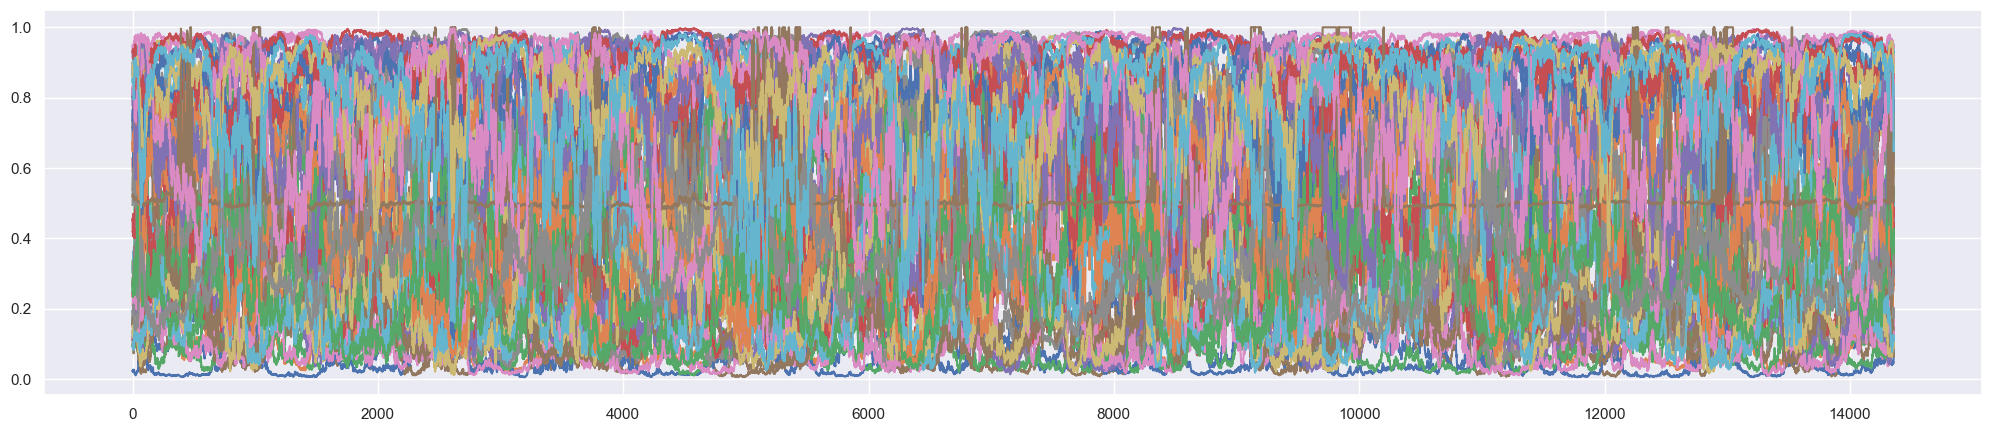

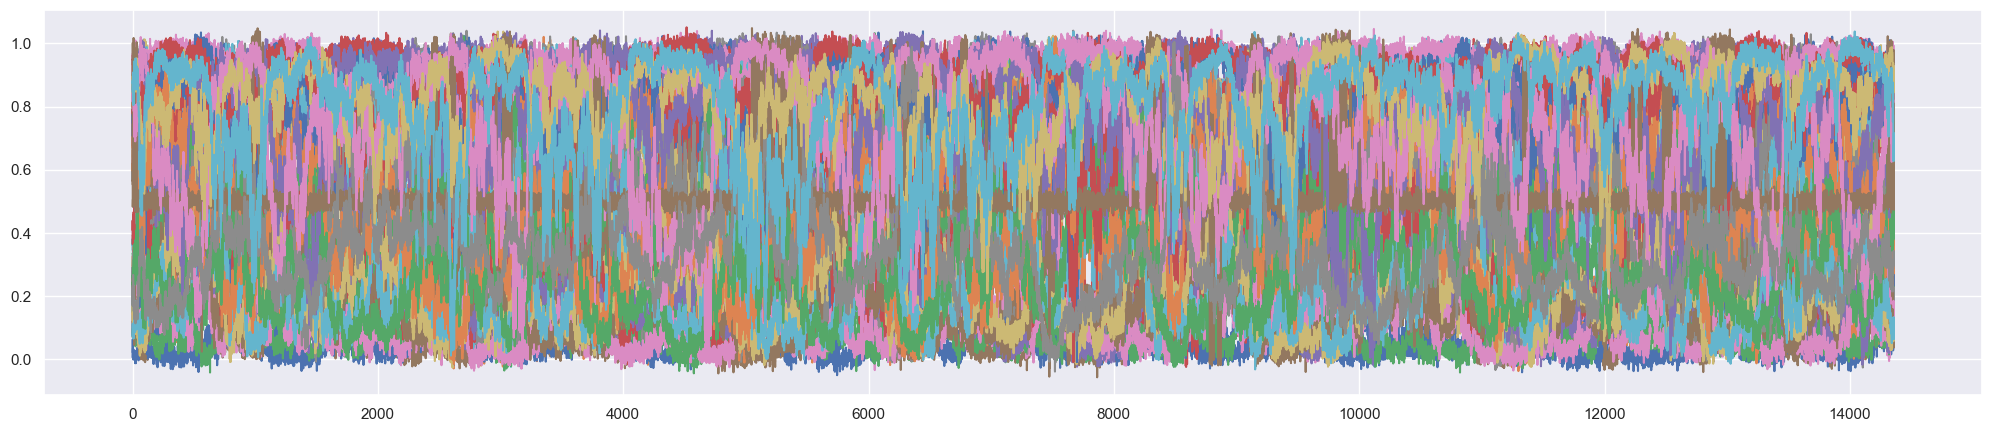

In [90]:
#expanding forecast
ewf = np.load(f"{RESULT_DIR}{dgpIndex}/{experimentName}/expandingForecast.npy")
plt.plot(ewf);
plt.figure()
plt.plot(y_test);


In [91]:
ewmsfe = (y_test - ewf)**2
print("Mean ewfe", np.mean(ewmsfe))

Mean ewfe 0.002156079


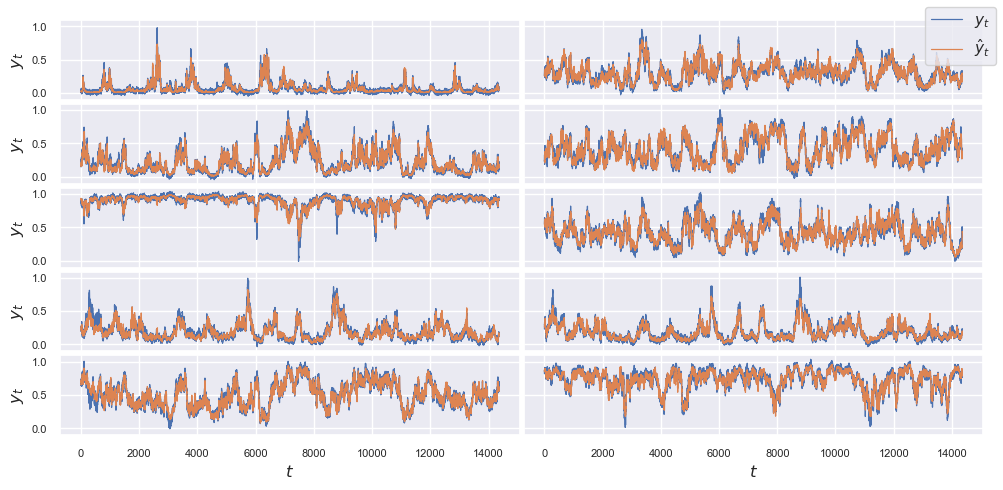

In [92]:
nCols = 2
offset = 0
nShow=10
skipSeries = 10
fig,axs = plt.subplots(int(nShow/nCols),nCols, sharey=True, sharex=True, figsize=(10,5))
f_test_hat_trans = cca.predict(f_test_hat)
for i, ax in enumerate(axs.flatten()):
    ax.plot(y_test[:,skipSeries+i], label="$y_t$", linewidth=0.9)
    ax.plot(ewf[:,skipSeries+i], label="$\hat{y}_t$", linewidth=0.9)
    #ax.set_ylabel('$\mathbf{f}_t$')
    if i >= len(axs.flatten())-nCols:
        ax.set_xlabel('$t$')
    if i % nCols == 0:
        ax.set_ylabel('$y_t$')
        ax.tick_params(labelsize=8)
        
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)     
fig.tight_layout()
plt.subplots_adjust(wspace=0.008, hspace=0.05);
axs.flatten()[-1].tick_params(labelsize=8)

# diebold mariano

In [59]:
#PCA forecast
from sklearn.decomposition import PCA
pca = PCA(n_components=cfg.factor_dim)
pca_f_train_hat = pca.fit_transform(y_train)

pca_f_test_hat = pca.transform(y_test)
pca_y_test_hat = pca.inverse_transform(f_test_hat)

pca_f_val_hat = pca.transform(y_val)
pca_f_hat = np.concatenate([f_train_hat, f_val_hat])
pca_model = VAR(f_hat)
pca_res = model.fit(maxlags=10, ic='aic')
pca_test_model = VAR(np.concatenate([f_hat, f_test_hat]))
pca_f_test_pred = test_model.predict(res.params, lags=res.k_ar)[cfg.T_train + cfg.T_val:]
pca_y_test_pred = pca.inverse_transform(f_test_pred)

In [57]:
pip install dieboldmariano

Note: you may need to restart the kernel to use updated packages.


In [84]:
from dieboldmariano import dm_test
T = y_test[2:]
F = y_test_pred
G = pca_y_test_pred
e1 = np.mean((T-F)**2, axis=1)
e2 = np.mean((T-G)**2, axis=1)

dm_test(V=np.zeros(e1.shape[0]), P1=e1, P2=e2, one_sided=True, loss= lambda a,b: b)

(-512.9607259883179, 0.0)

In [85]:
import numpy as np
from scipy.stats import norm

def diebold_mariano_test(e1, e2, h=1, alpha=0.05, two_tailed=True):
    """
    Perform the Diebold-Mariano test to compare forecast accuracy between two models.

    Args:
        e1 (list or numpy array): Errors of model F.
        e2 (list or numpy array): Errors of model G.
        h (int): Forecast horizon (default: 1).
        alpha (float): Significance level (default: 0.05).
        two_tailed (bool): Use two-tailed test (default: True).

    Returns:
        float: Test statistic.
        float: P-value.
        bool: Whether to reject the null hypothesis.
    """
    n = len(e1)
    d = np.square(e1) - np.square(e2)
    d_mean = np.mean(d)
    d_var = np.var(d)

    if n <= h:
        raise ValueError("Number of observations (n) should be greater than the forecast horizon (h).")

    dm_stat = d_mean / np.sqrt((d_var / n))
    p_value = 2 * (1 - norm.cdf(abs(dm_stat)))

    if not two_tailed:
        p_value /= 2

    reject_null = p_value < alpha

    return dm_stat, p_value, reject_null

#usage
T = y_test[2:]
F = y_test_pred
G = pca_y_test_pred
e1 = np.mean((T-F)**2, axis=1)
e2 = np.mean((T-G)**2, axis=1)

dm_stat, p_value, reject_null = diebold_mariano_test(e1, e2, two_tailed=False)
print("Diebold-Mariano test statistic:", dm_stat)
print("P-value:", p_value)
print("Reject null hypothesis:", reject_null)

Diebold-Mariano test statistic: -253.3806435590751
P-value: 0.0
Reject null hypothesis: True


In [79]:
e2.shape

(14358,)